# DPU example: Resnet50
----

## Aim/s
* This notebooks shows an example of DPU applications. The application,as well as the DPU IP, is pulled from the official 
[Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).

## References
* [Vitis AI Github Repository](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

## Last revised
* Mar 3, 2021
    * Initial revision
* Dec 17, 2021
    * Calling load_model after importing cv2 to avoid memory allocation issues on KV260
----

## 1. Prepare the overlay
We will download the overlay onto the board. 

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")

## 2. Utility functions

In this section, we will prepare a few functions for later use.

In [2]:
import os
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

The `load_model()` method will automatically prepare the `graph`
which is used by VART.

**Note** For the KV260 board you may see TLS memory allocation errors if cv2 gets loaded before loading the vitis libraries in the Jupyter Lab environment. Make sure to load cv2 first in these cases.

In [3]:
overlay.load_model("dpu_resnet50.xmodel")

Let's first define a few useful preprocessing functions. These functions
will make sure the DPU can take input images with arbitrary sizes.

In [4]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

MEANS = [_B_MEAN,_G_MEAN,_R_MEAN]

def resize_shortest_edge(image, size):
    H, W = image.shape[:2]
    if H >= W:
        nW = size
        nH = int(float(H)/W * size)
    else:
        nH = size
        nW = int(float(W)/H * size)
    return cv2.resize(image,(nW,nH))

def mean_image_subtraction(image, means):
    B, G, R = cv2.split(image)
    B = B - means[0]
    G = G - means[1]
    R = R - means[2]
    image = cv2.merge([R, G, B])
    return image

def BGR2RGB(image):
    B, G, R = cv2.split(image)
    image = cv2.merge([R, G, B])
    return image

def central_crop(image, crop_height, crop_width):
    image_height = image.shape[0]
    image_width = image.shape[1]
    offset_height = (image_height - crop_height) // 2
    offset_width = (image_width - crop_width) // 2
    return image[offset_height:offset_height + crop_height, offset_width:
                 offset_width + crop_width, :]

def normalize(image):
    image=image/256.0
    image=image-0.5
    image=image*2
    return image

def preprocess_fn(image, crop_height = 224, crop_width = 224):
    image = resize_shortest_edge(image, 256)
    image = mean_image_subtraction(image, MEANS)
    image = central_crop(image, crop_height, crop_width)
    return image

We will also define a few functions to calculate softmax and provide 
the output class after running a DPU task.

In [5]:
def calculate_softmax(data):
    result = np.exp(data)
    return result

def predict_label(softmax):
    with open("img/words.txt", "r") as f:
        lines = f.readlines()
    return lines[np.argmax(softmax)-1]

Keep in mind that our original images are 640x480 so we need to preprocess them
later to make sure it fits our model.

In [6]:
image_folder = 'img'
original_images = [i for i in os.listdir(image_folder) if i.endswith("JPEG")]
total_images = len(original_images)

## 3. Use VART
Now we should be able to use VART to do image classification.

In [7]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])

softmax = np.empty(outputSize)

We can define a few buffers to store input and output data. They will be reused
during multiple runs.

In [8]:
output_data = [np.empty(shapeOut, dtype=np.float32, order="C")]
input_data = [np.empty(shapeIn, dtype=np.float32, order="C")]
image = input_data[0]

Remember that we have a list of `original_images`. 
We can now define a new function `run()` which takes the image index as 
the input, and calculate the softmax as the classification result.
With the argument `display` set to `True`, the original image as well as the
predicted label can be rendered.

It is obvious that the range of `image_index` should be [0, `total_images`-1].

In [9]:
def run(image_index, display=False):
    preprocessed = preprocess_fn(cv2.imread(
        os.path.join(image_folder, original_images[image_index])))
    image[0,...] = preprocessed.reshape(shapeIn[1:])
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    temp = [j.reshape(1, outputSize) for j in output_data]
    softmax = calculate_softmax(temp[0][0])
    if display:
        display_image = cv2.imread(os.path.join(
            image_folder, original_images[image_index]))
        _, ax = plt.subplots(1)
        _ = ax.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
        print("Classification: {}".format(predict_label(softmax)))

Let's run it for 1 image and print out the predicted label.

Classification: Arctic fox, white fox, Alopex lagopus



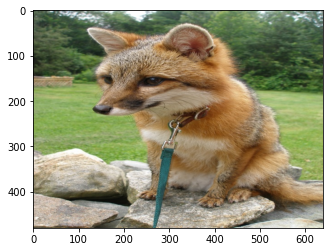

In [10]:
run(1, display=True)

We can also run it for multiple images as shown below. In this example
we have only used 1 thread; in principle, users should be able to boost
the performance by employing more threads.

In [11]:
time1 = time.time()
[run(i) for i in range(total_images)]
time2 = time.time()
fps = total_images/(time2-time1)
print("Performance: {} FPS".format(fps))

Performance: 25.196311536959723 FPS


We will need to remove references to `vart.Runner` and let Python garbage-collect
the unused graph objects. This will make sure we can run other notebooks without
any issue.

In [12]:
del overlay
del dpu

----

Copyright (C) 2021 Xilinx, Inc

SPDX-License-Identifier: Apache-2.0 License

----

----